# Training Autoencoder to De-Noise & De-Blur Images

This Jupyter Notebook runs you through how this project can be used to train a Autoencoder (AE) to de-blur (sharpen) & de-noise images of the same subject as the images in the data subdirectory of this project. For this project, I prefer working with Notebooks over training from command line, since the continuous visual monitoring of the generated output by the AE does not become a hindrance.

In [1]:
# IMPORT STATEMENTS
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

from ae import *

In [2]:
##### HYPERPARAMETERS #####
image_input_dims = (64, 64, 3) # (img height, img width, color channels)
latent_dim = 1048 # latent space

# Note: it is important to give each model (model_name parameter) a distinctive name 
#(where & how model & progress are saved depend on it)
model_name = "AE"

In [3]:
# TRAIN-TEST SPLIT
train_set, test_set = split_image_data(test_size = 0.05, folder = 'data')

overall dataset size:  10000
-------------------------------
train dataset size:  8500
test dataset size:  1500


input images batch shape:  (64, 64, 64, 3)
output images batch shape:  (64, 64, 64, 3)


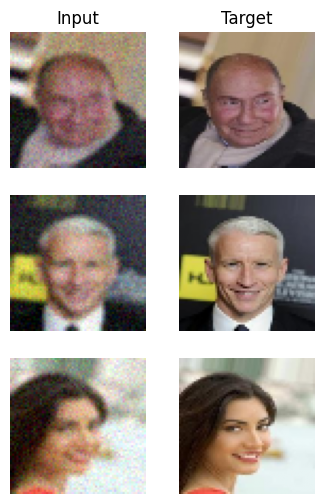

In [4]:
# CONFIGURE THE DATA GENERATORS FOR TRAIN AND TEST SETS
batch_size = 64
blur_kernel = 3
noise_var = 0.0025

train_gen = ae_data_generator(filenames = train_set, 
                              batch_size = batch_size, 
                              img_dims = image_input_dims,
                              blur_kernel = blur_kernel,
                              noise_var = noise_var)

test_gen = ae_data_generator(filenames = test_set, 
                             batch_size = batch_size, 
                             img_dims = image_input_dims,
                             blur_kernel = blur_kernel,
                             noise_var = noise_var)

input_imgs, target_imgs = train_gen.__getitem__(0)

# CHECK IF THE INPUT/OUTPUT SHAPES CORRESPOND
print('input images batch shape: ', str(input_imgs.shape))
print('output images batch shape: ', str(target_imgs.shape))

# VISUALLY INSPECT THE INPUT AND TARGET GENERATED
fig = plt.figure(figsize = (4, 6))
ind_targets = [2,4,6]
ind_inputs = [1,3,5]
for i in range(3):
    plt.subplot(3, 2, ind_inputs[i])
    plt.imshow(input_imgs[i])
    plt.axis('off')
    if i == 0:
        plt.title("Input")
    
    plt.subplot(3, 2, ind_targets[i])
    plt.imshow(target_imgs[i])
    plt.axis('off')
    if i == 0:
        plt.title("Target")
    pass

plt.show()

In [21]:
np.max(input_imgs)

1.0

In [5]:
# CREATE/LOAD MODEL ARCHITECTURE
encoder = initialize_encoder(input_dims = image_input_dims,
                             latent_dim = latent_dim,
                             max_filters = 1024, 
                             kernel_size = 3,
                             leaky_relu_slope = 0.2,
                             model_name = 'encoder')

decoder = initialize_decoder(input_dims = image_input_dims,
                             latent_dim = latent_dim,
                             max_filters = 1024, 
                             kernel_size = 3,
                             leaky_relu_slope = 0.2, # use PReLU
                             model_name = 'decoder')

# # OR LOAD PREVIOUSLY TRAINED MODELS
# encoder = load_pretrained_model(file = model_name + "/encoder.keras", folder = "trained_models")
# decoder = load_pretrained_model(file = model_name + "/decoder.keras", folder = "trained_models")

encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 BN_1 (BatchNormalization)   (None, 32, 32, 128)       512       
                                                                 
 lky_ReLu_1 (LeakyReLU)      (None, 32, 32, 128)       0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 BN_2 (BatchNormalization)   (None, 16, 16, 256)       1024      
                                                                 
 lky_ReLu_2 (LeakyReLU)      (None, 16, 16, 256)       0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 8, 8, 512)         1180

In [6]:
# CREATE OVERALL AUTOENCODER MODEL
ae = AE(encoder, decoder, model_name)

In [7]:
# COMPILE MODEL
ae.compile(optimizer = Adam())

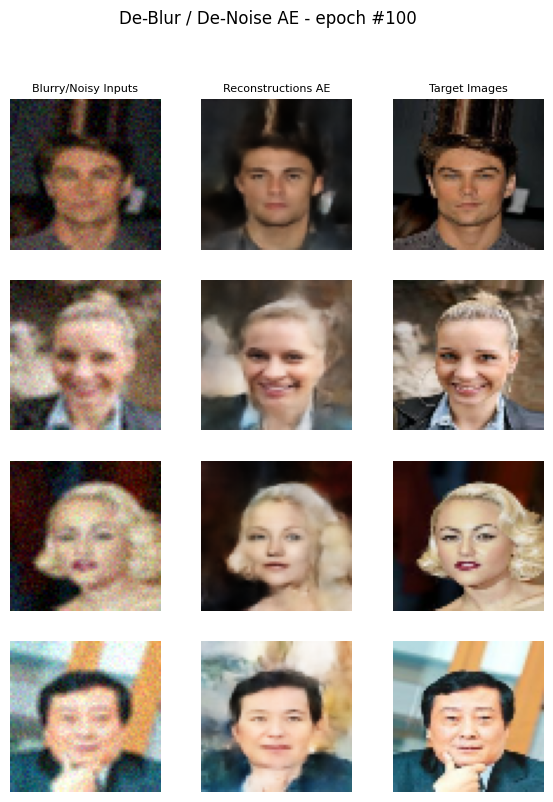

Test Reconstruction Loss: tf.Tensor(6038.5537, shape=(), dtype=float32)
133/133 [==============================] - 10s 71ms/step - loss: 23.0951


In [12]:
# TRAIN THE MODEL
batch_size = 64
epochs = 50
history = ae.fit(train_gen, 
                 epochs = epochs, 
                 callbacks = [monitor_ae_performance(data_gen = test_gen, folder = 'training_progress')])

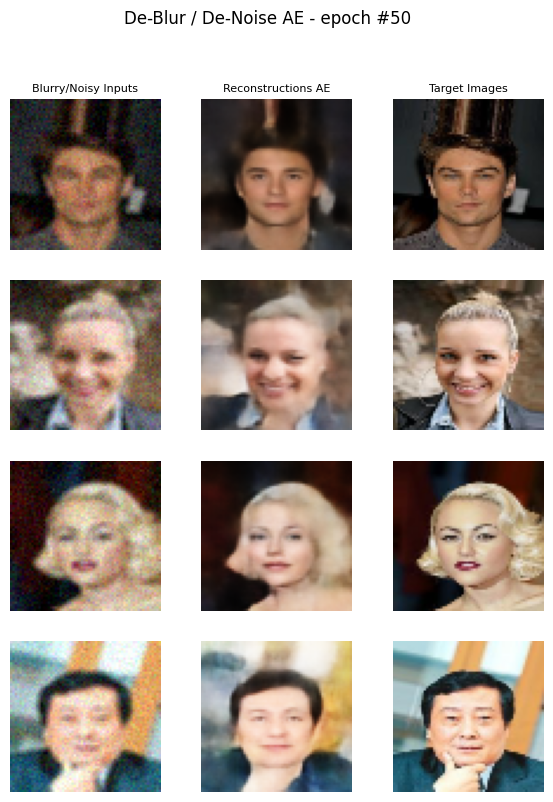

Test Reconstruction Loss: tf.Tensor(94.9893, shape=(), dtype=float32)
133/133 [==============================] - 9s 71ms/step - loss: 43.7025


In [8]:
# TRAIN THE MODEL
batch_size = 64
epochs = 50
history = ae.fit(train_gen, 
                 epochs = epochs, 
                 callbacks = [monitor_ae_performance(data_gen = test_gen, folder = 'training_progress')])

In [9]:
# SAVE THE MODEL
save_ae_model(model = ae, folder = "trained_models")

In [10]:
# CREATE GIF OF THE TRAINING PROGRESS
create_gif(fname = ae.name + '_training.gif', 
           train_progress_folder = 'training_progress/' + ae.name, 
           loop = 30, duration = 180)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 80.63it/s]


## Considerations

It is obvious that during the process of de-blurring and de-noising information is lost. The model "guesses" details based on both the blurry/noisy features of the input image and the overall set of facial features present in the dataset it is trained on. Therefore, one would expect the model to output a greater variety of details when trained on larger datasets.

-----------------

## De-Blur & De-Noise WGAN Generated Images
Let's evaluate how much we can improve the results generated by our WGAN...

In [33]:
# IMPORT STATEMENTS FOR THE WGAN
from wgan.model import *
from wgan.utils import *

In [13]:
# LOAD WGAN GENERATOR FOR GENERATING IMAGES
generator = load_pretrained_model(file = "WGAN/generator.keras", folder = "trained_models")

Model: [generator] was successfully loaded!


In [28]:
# RUN RANDOM NOISE THROUGH WGAN GENERATOR & DE-BLUR/DE-NOISE USING THE AE
generated_images = generator(tf.random.normal([16, generator.input.shape[-1]]))
generated_images = ((generated_images * 127.5) + 127.5)/255. # scale predicitons from [-1,1] to [0,255]
gen_imgs = generated_images.numpy()
gen_imgs_deblur_denoise = ae(gen_imgs)

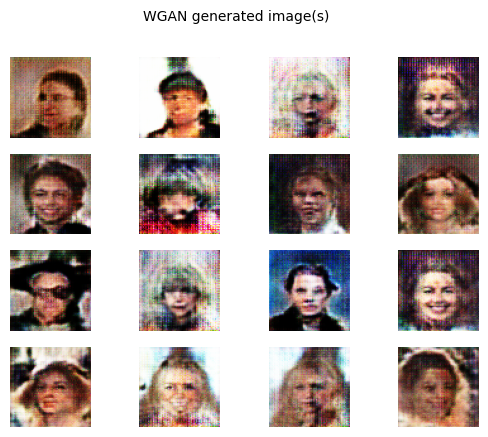

In [29]:
# SHOW WGAN GENERATED IMAGES
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(gen_imgs[i,])
    plt.axis('off')
    pass

plt.suptitle('WGAN generated image(s)', fontsize = 10)
plt.show()

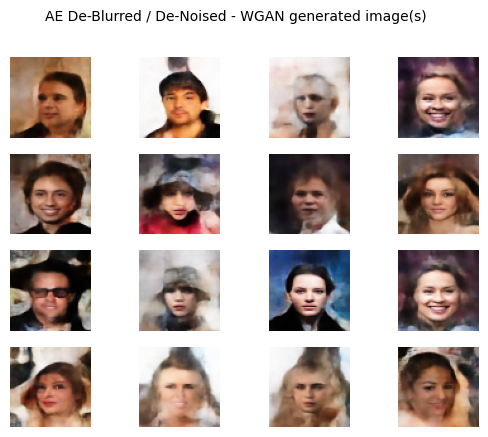

In [32]:
# SHOW WGAN GENERATED IMAGES AFTER DE-BLURRING & DE-NOISING (USING THE AE)
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(gen_imgs_deblur_denoise[i,])
    plt.axis('off')
    pass

plt.suptitle('AE De-Blurred / De-Noised - WGAN generated image(s)', fontsize = 10)
plt.show()